In [246]:
#!pip install ucimlrepo

In [247]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import statistics
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from ucimlrepo import fetch_ucirepo
from functools import partial
import warnings

warnings.filterwarnings('ignore')


In [248]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [249]:
import train_tabular_utils as tt
import cv_split_utils
import enums
import data_utils

In [250]:
class Config:
    RUN_MODE = "LOCAL"
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    TARGET_COL_NAME = "Target"        
    SCALER = enums.Scaler.StandardScaler
    METRIC = enums.Metrics.ACCURACY
    # These values are more dynamic   
    MODEL_TYPE = enums.ModelName.CatBoost
    NUM_TUNING_TRIALS = 2
    TUNE_ON_SINGLE_FOLD = True
    TRAIN_SINGLE_FOLD = False    
    PERSIST_MODEL = False
    USE_OPENFE_FEATURES = True
    CREATE_MANUAL_FEATURES = False
    USE_ORIGINAL_DATA = True

COLS_TO_LEAVE = ["id", "Target", "kfold"]
CPU_COUNT = os.cpu_count()

DATA_READPATH = "./data/"
DATA_WRITEPATH = "./output/"
SUBMISSION_FILEPATH = DATA_READPATH
if Config.RUN_MODE == "KAGGLE":    
    DATA_READPATH = "/kaggle/input/playground-series-s4e6/"
    if Config.USE_OPENFE_FEATURES:
        DATA_READPATH = "/kaggle/input/ps4e6-openfe/"
    SUBMISSION_FILEPATH = "/kaggle/input/playground-series-s4e6/"
    DATA_WRITEPATH = "/kaggle/working/"

In [251]:
model_static_params = {
    enums.ModelName.XGBoost: {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "seed": Config.RANDOM_SEED,
        "verbosity": 0,
    },
    enums.ModelName.LGBM: {
        "objective": "root_mean_squared_error",
        "metric": 'rmse',
        "verbosity": -1,    # <0: fatal, =0: error (warn), =1: info, >1: debug
        "boosting_type": "gbdt"
    },
    enums.ModelName.CatBoost: {
        "objective": "MultiClass",
        "verbose": 0,
        "random_seed": Config.RANDOM_SEED,
        "eval_metric": "Accuracy",
        'grow_policy':  'Lossguide',
        #'bootstrap_type': 'Poisson',
        'task_type': 'CPU'
    },
    enums.ModelName.RandomForest: {
        "random_state": Config.RANDOM_SEED,
        "n_jobs": -1
    }
}

In [252]:
# For RandomForest
# tuned_model_params = {'n_estimators': 703, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 4, 
#                 'max_features': 'log2', 'random_state': Config.RANDOM_SEED}
tuned_model_params = None

In [253]:
# fetch original dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
df_train_orig = predict_students_dropout_and_academic_success.data.features 
df_train_orig[Config.TARGET_COL_NAME] = predict_students_dropout_and_academic_success.data.targets[Config.TARGET_COL_NAME]
# rename column 'Marital Status' to 'Marital status'
df_train_orig = df_train_orig.rename(columns={'Marital Status': 'Marital status'})

In [254]:
# no missing values in original data
na_orig = df_train_orig.isna().sum()
na_orig.loc[na_orig > 0]

Series([], dtype: int64)

In [255]:
if Config.USE_OPENFE_FEATURES and not Config.USE_ORIGINAL_DATA:
    print("using generated openfe features only on train data")
    df_train = pd.read_csv(DATA_READPATH + "train_openfe.csv")    
    df_test = pd.read_csv(DATA_READPATH + "test_openfe.csv")
elif Config.USE_OPENFE_FEATURES and Config.USE_ORIGINAL_DATA:
    print("using generated openfe features on both train and original data")
    df_train = pd.read_csv(DATA_READPATH + "train_orig_openfe.csv")    
    df_test = pd.read_csv(DATA_READPATH + "test_orig_openfe.csv")
else:    
    df_train = pd.read_csv(DATA_READPATH + "train.csv")
    df_train = df_train.drop("id", axis=1)    
    df_test = pd.read_csv(DATA_READPATH + "test.csv")
    df_test = df_test.drop("id", axis=1)
    if Config.USE_ORIGINAL_DATA:
        # add df_train_orig rows to df_train
        df_train = pd.concat([df_train, df_train_orig], axis=0, ignore_index=True)

using generated openfe features on both train and original data


In [256]:
# Label encoding of target values
le = LabelEncoder()
le.fit(df_train[Config.TARGET_COL_NAME])
df_train[Config.TARGET_COL_NAME] = le.transform(df_train[Config.TARGET_COL_NAME])
list(le.classes_)

['Dropout', 'Enrolled', 'Graduate']

In [257]:
def process_col_name(cols_list):
    processed_cols_list = []
    for item in cols_list:
        # Remove round brackets but keep the text inside them
        item_no_brackets = re.sub(r'[\(\)]', '', item)
        # Remove single quotes
        item_no_quotes = item_no_brackets.replace("'", "")
        # Replace spaces with underscores
        item_processed = item_no_quotes.replace(' ', '_')
        # Append to the processed list
        processed_cols_list.append(item_processed)
    return processed_cols_list

In [258]:
train_cols_list = df_train.columns.to_list()
test_cols_list = df_test.columns.to_list()
train_processed_cols_list = process_col_name(train_cols_list)
test_processed_cols_list = process_col_name(test_cols_list)
df_train.columns = train_processed_cols_list
df_test.columns = test_processed_cols_list

In [259]:
# feature engineering
def create_features(df):
    # (Tuition_fees_up_to_date*Curricular_units_2nd_sem_approved)
    df["f_1"] = df["Tuition_fees_up_to_date"] * df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_1st_sem_approved+Curricular_units_2nd_sem_approved)
    df["f_2"] = df["Curricular_units_1st_sem_approved"] + df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade*Curricular_units_2nd_sem_approved)
    df["f_3"] = df["Curricular_units_2nd_sem_grade"] * df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade+Curricular_units_2nd_sem_approved)
    df["f_4"] = df["Curricular_units_2nd_sem_grade"] + df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade+Scholarship_holder)
    df["f_5"] = df["Curricular_units_2nd_sem_grade"] + df["Scholarship_holder"]
    # (Curricular_units_1st_sem_grade+Scholarship_holder)
    df["f_6"] = df["Curricular_units_1st_sem_grade"] + df["Scholarship_holder"]
    # (Curricular_units_2nd_sem_enrolled-Curricular_units_2nd_sem_approved)
    df["f_7"] = df["Curricular_units_2nd_sem_enrolled"] - df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_1st_sem_enrolled-Curricular_units_2nd_sem_approved)
    df["f_8"] = df["Curricular_units_1st_sem_enrolled"] - df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade-Curricular_units_1st_sem_evaluations)
    df["f_9"] = df["Curricular_units_2nd_sem_grade"] - df["Curricular_units_1st_sem_evaluations"]
    # (Curricular_units_1st_sem_grade/Age_at_enrollment)
    df["f_10"] = df["Curricular_units_1st_sem_grade"] / df["Age_at_enrollment"]
    # (Curricular_units_1st_sem_evaluations-Curricular_units_2nd_sem_approved)
    df["f_11"] = df["Curricular_units_1st_sem_evaluations"] - df["Curricular_units_2nd_sem_approved"]
    # GroupByThenRank(Curricular_units_2nd_sem_approved,Curricular_units_1st_sem_enrolled)    
    df["f_12"] = df.groupby('Curricular_units_1st_sem_enrolled')['Curricular_units_2nd_sem_approved'].rank(method="dense", ascending=False)
    # GroupByThenRank(Curricular_units_2nd_sem_approved,Mothers_occupation)
    df["f_13"] = df.groupby('Mothers_occupation')['Curricular_units_2nd_sem_approved'].rank(method="dense", ascending=False)
    # GroupByThenRank(Scholarship_holder,Age_at_enrollment)
    df["f_14"] = df.groupby('Age_at_enrollment')['Scholarship_holder'].rank(method="dense", ascending=False)
    # GroupByThenRank(Scholarship_holder,Curricular_units_2nd_sem_approved)
    df["f_15"] = df.groupby('Curricular_units_2nd_sem_approved')['Scholarship_holder'].rank(method="dense", ascending=False)
    # CombineThenFreq(Course,Curricular_units_1st_sem_approved)
    df["f_16"] = df.groupby('Course')['Curricular_units_1st_sem_approved'].transform('count')
    return df

In [260]:
if Config.CREATE_MANUAL_FEATURES:
    df_train = create_features(df_train)
    df_test = create_features(df_test)

In [261]:
na_val = df_train.isna().sum()
null_features = na_val.loc[na_val > 0].index.values.tolist()
null_features

['autoFE_f_1',
 'autoFE_f_2',
 'autoFE_f_3',
 'autoFE_f_5',
 'autoFE_f_6',
 'autoFE_f_7',
 'autoFE_f_10',
 'autoFE_f_13',
 'autoFE_f_15',
 'autoFE_f_16',
 'autoFE_f_17',
 'autoFE_f_18',
 'autoFE_f_19',
 'autoFE_f_23',
 'autoFE_f_31',
 'autoFE_f_37',
 'autoFE_f_42',
 'autoFE_f_47']

In [262]:
cat_features = ['Marital_status', 'Application_mode', 'Course', 'Daytime/evening_attendance', 'Previous_qualification',
    'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Displaced',
    'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date','Gender', 'Scholarship_holder', 'International']

In [263]:
cont_features = [x for x in df_train.dtypes[df_train.dtypes == "float"].index.values if x not in null_features]
int_features = [x for x in df_train.dtypes[df_train.dtypes == "int"].index.values if x not in COLS_TO_LEAVE+null_features]
feature_cols = df_test.columns.to_list()
feature_cols_after_fe = [x for x in df_train.columns if x not in COLS_TO_LEAVE+null_features]

In [264]:
# for categorical features find the categories to be used for one hot encoding
int_feature_categories = []
for int_feature in int_features:
    int_feature_categories.append(sorted(df_train[int_feature].unique()))

In [265]:
print(f"len(feature_cols_after_fe)={len(feature_cols_after_fe)}")
print(feature_cols_after_fe)

len(feature_cols_after_fe)=68
['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytime/evening_attendance', 'Previous_qualification', 'Previous_qualification_grade', 'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Admission_grade', 'Displaced', 'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'Age_at_enrollment', 'International', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate', 'Inflation_rate', 'GDP', 'autoFE_f_0', 'autoFE_f

In [266]:
# preprocessing
preprocessor = None
scaler = StandardScaler()
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore", categories=int_feature_categories)
if Config.MODEL_TYPE == enums.ModelName.LogisticRegression:
    preprocessor = ColumnTransformer(
        transformers=[                
            ("scaler", scaler, feature_cols_after_fe),
            ("onehot", onehot_encoder, int_features),                
        ], remainder="passthrough"
    )
else:
    preprocessor = ColumnTransformer(
        transformers=[                
            ("scaler", scaler, cont_features)     
        ], remainder="passthrough"
    )

In [267]:
def get_catboost_tuning_params(trial):
    params_dynamic = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000, step=50),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        #'subsample': trial.suggest_float('subsample', 0.5, 1),
        # comment colsample_bylevel for GPU training
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'num_leaves': trial.suggest_int('num_leaves', 4, 256, step=4),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'random_strength': trial.suggest_loguniform('random_strength', 0.01, 10),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 500, step=20),
        'max_bin': trial.suggest_int('max_bin', 32, 255)
    }
    return {**model_static_params[enums.ModelName.CatBoost], **params_dynamic}

In [268]:
def get_model_tuning_params(trial, model_name):    
    if model_name == enums.ModelName.RandomForest:
        return {        
            "n_estimators": trial.suggest_int("n_estimators", 200, 3000, step=100),
            "max_depth": trial.suggest_int("max_depth", 10, 30),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 16),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
            "max_features": trial.suggest_categorical("max_features", ["log2", "sqrt", None])
        }
    if model_name == enums.ModelName.CatBoost:
        return get_catboost_tuning_params(trial)    

In [269]:
def hyperparams_tuning_objective(trial, model_name, preprocessor, df,  
                                 feature_cols, metric, target_col_name, single_fold=False, num_folds=5):               
    model_params = get_model_tuning_params(trial, model_name)    
    fold_metrics_model, _, _ = tt.train_and_validate(
                                        model_name=model_name,
                                        model_params=model_params,
                                        preprocessor=preprocessor,
                                        df=df,
                                        feature_cols=feature_cols,
                                        target_col_name=target_col_name,
                                        metric=metric,
                                        single_fold=single_fold,
                                        num_folds=num_folds,
                                        suppress_print=True
                                    )
    fold_metrics = [x[0] for x in fold_metrics_model]
    mean_metric = statistics.mean(fold_metrics)                
    return mean_metric

In [270]:
def tune_model_params(study_name, study_direction, num_trials, model_name, 
                      preprocessor, df,  feature_cols, metric, target_col_name, 
                      single_fold=False, num_folds=5):
    model_params_tuning_obj_partial = partial(
        hyperparams_tuning_objective,
        model_name=model_name,        
        preprocessor=preprocessor,        
        df=df,
        feature_cols=feature_cols,
        metric=metric,
        target_col_name=target_col_name,
        single_fold=single_fold,
        num_folds=num_folds
    )
    study = optuna.create_study(direction=study_direction, study_name=study_name)
    study.optimize(model_params_tuning_obj_partial, n_trials=num_trials)
    best_trial = study.best_trial
    print(f"Best trial: number = {best_trial.number}, value = {best_trial.value}, params = {best_trial.params}")
    return best_trial.params

In [271]:
df_train = cv_split_utils.strat_kfold_dataframe(df_train, 
                                                target_col_name=Config.TARGET_COL_NAME, 
                                                random_state=Config.RANDOM_SEED, 
                                                num_folds=Config.NUM_FOLDS)

In [272]:
if tuned_model_params is None:
    #df = df_train.sample(frac=0.1, random_state=Config.RANDOM_SEED)
    tuned_model_params = tune_model_params(
                            study_name=Config.MODEL_TYPE + "_ModelTuning", 
                            study_direction="maximize",
                            num_trials=Config.NUM_TUNING_TRIALS,
                            model_name=Config.MODEL_TYPE,
                            preprocessor=preprocessor,
                            df=df_train,
                            feature_cols=feature_cols_after_fe,
                            metric=Config.METRIC,
                            target_col_name=Config.TARGET_COL_NAME,
                            single_fold=Config.TUNE_ON_SINGLE_FOLD,
                            num_folds=Config.NUM_FOLDS
                    )

[I 2024-06-12 17:26:41,672] A new study created in memory with name: CatBoost_ModelTuning


[I 2024-06-12 17:28:34,383] Trial 0 finished with value: 0.8304404225091111 and parameters: {'learning_rate': 0.02251037098391677, 'n_estimators': 4450, 'max_depth': 16, 'min_data_in_leaf': 13, 'colsample_bylevel': 0.9326921876156375, 'num_leaves': 112, 'reg_lambda': 55.59523086567673, 'random_strength': 0.5022549071223417, 'early_stopping_rounds': 150, 'max_bin': 203}. Best is trial 0 with value: 0.8304404225091111.
[I 2024-06-12 17:29:22,546] Trial 1 finished with value: 0.832911236024461 and parameters: {'learning_rate': 0.45126024670762294, 'n_estimators': 3700, 'max_depth': 7, 'min_data_in_leaf': 73, 'colsample_bylevel': 0.8908705634626486, 'num_leaves': 120, 'reg_lambda': 98.46961225632553, 'random_strength': 0.016359736302592447, 'early_stopping_rounds': 210, 'max_bin': 253}. Best is trial 1 with value: 0.832911236024461.


Best trial: number = 1, value = 0.832911236024461, params = {'learning_rate': 0.45126024670762294, 'n_estimators': 3700, 'max_depth': 7, 'min_data_in_leaf': 73, 'colsample_bylevel': 0.8908705634626486, 'num_leaves': 120, 'reg_lambda': 98.46961225632553, 'random_strength': 0.016359736302592447, 'early_stopping_rounds': 210, 'max_bin': 253}


In [273]:
model_params = None
params_static = model_static_params.get(Config.MODEL_TYPE)
if params_static is not None and tuned_model_params is not None:
    model_params = {**model_static_params[Config.MODEL_TYPE], **tuned_model_params}
else:
    model_params = tuned_model_params

In [274]:
%%time
fold_metrics_model, df_oof_preds, preprocessor = tt.train_and_validate(
        model_name=Config.MODEL_TYPE,
        model_params=model_params,
        preprocessor=preprocessor,
        df=df_train,
        feature_cols=feature_cols_after_fe,
        target_col_name=Config.TARGET_COL_NAME,
        metric=Config.METRIC,
        single_fold=Config.TRAIN_SINGLE_FOLD,
        num_folds=Config.NUM_FOLDS,
        suppress_print=False
)

Fold 0 - CatBoost - ACCURACY : 0.832911236024461
Fold 1 - CatBoost - ACCURACY : 0.8280931496695287
Fold 2 - CatBoost - ACCURACY : 0.8295033358042995
Fold 3 - CatBoost - ACCURACY : 0.8289473684210527
Fold 4 - CatBoost - ACCURACY : 0.8303681739560168
CatBoost metric=ACCURACY CV score = 0.8299646660571768
CatBoost Mean ACCURACY = 0.8299646527750717, std = 0.0016489625142837273
CPU times: user 19min 31s, sys: 1min 19s, total: 20min 51s
Wall time: 3min 10s


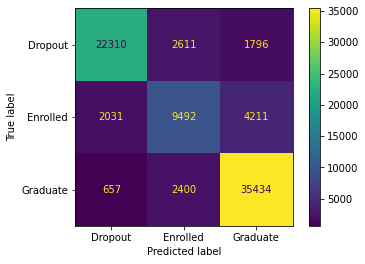

In [313]:
def get_agg_confusion_matrix(fold_metrics_model, preprocessor, df_train, feature_cols, target_col_name, num_folds=5):
    cm = []
    for fold in range(Config.NUM_FOLDS):
        df_train_fold, df_val_fold = tt.get_fold_df(df_train, fold)
        train_X, train_y, val_X, val_y = tt.get_train_val_nparray(df_train_fold, df_val_fold, feature_cols, target_col_name)
        if preprocessor is not None:
            val_X = preprocessor.transform(val_X)
        val_preds = fold_metrics_model[fold][1].predict(val_X)
        cm.append(confusion_matrix(val_y, val_preds))
    # sum the individual confusion matrices
    agg_cm = np.sum(cm, axis=0)
    return agg_cm

In [ ]:
agg_cm = get_agg_confusion_matrix(fold_metrics_model1, preprocessor, df_train, 
                                  feature_cols=feature_cols_after_fe, 
                                  target_col_name=Config.TARGET_COL_NAME, 
                                  num_folds=Config.NUM_FOLDS)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=agg_cm, display_labels=le.classes_)
disp.plot()
plt.show()

In [317]:
print(classification_report(df_oof_preds.Target.values, df_oof_preds.oof_preds.values, target_names=le.classes_))

              precision    recall  f1-score   support

     Dropout       0.89      0.84      0.86     26717
    Enrolled       0.66      0.60      0.63     15734
    Graduate       0.85      0.92      0.89     38491

    accuracy                           0.83     80942
   macro avg       0.80      0.79      0.79     80942
weighted avg       0.83      0.83      0.83     80942



In [275]:
tt.persist(
    model_name=Config.MODEL_TYPE, 
    fold_metrics_model=fold_metrics_model, 
    df_oof_preds=df_oof_preds, 
    persist_model=Config.PERSIST_MODEL, 
    output_path=DATA_WRITEPATH
)

Saved validation data predictions to df_val_preds_CatBoost.csv


In [276]:
test_preds_final = tt.get_test_preds_clf(fold_metrics_model, df_test, feature_cols_after_fe, 
                                         preprocessor=preprocessor, num_folds=Config.NUM_FOLDS)
# convert test_preds to string using labelencoder
test_preds_final = le.inverse_transform(test_preds_final)
print(f"test_preds_final shape: {test_preds_final.shape}")
df_submission = pd.read_csv(SUBMISSION_FILEPATH + 'sample_submission.csv')
df_submission[Config.TARGET_COL_NAME]= test_preds_final
df_submission.to_csv(DATA_WRITEPATH + f'submission_{Config.MODEL_TYPE}.csv',index=False)
df_submission.head()

test_X shape: (51012, 68)
combined_test_preds shape: (51012, 3)
test_preds_final shape: (51012,)


,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled


In [303]:
# Define a function to extract the part after '__' (vectorized for speed)
def extract_after_delimiter(text):
  return text.split("__", 1)[1] if len(text.split("__")) > 1 else text

features = preprocessor.get_feature_names_out()
# Apply the function to the feature names using lambda
features = list(map(extract_after_delimiter, features))
len(features)

60

In [287]:
model = fold_metrics_model[0][1]
df_feature_imp = pd.DataFrame()
df_feature_imp["f_name"] = features
df_feature_imp["f_imp"] = model.feature_importances_
df_feature_imp = df_feature_imp.sort_values(by="f_imp", ascending=False)

In [297]:
df_feature_imp.to_csv(DATA_WRITEPATH + "cb_feature_imp_orig_openfe.csv", index=False)

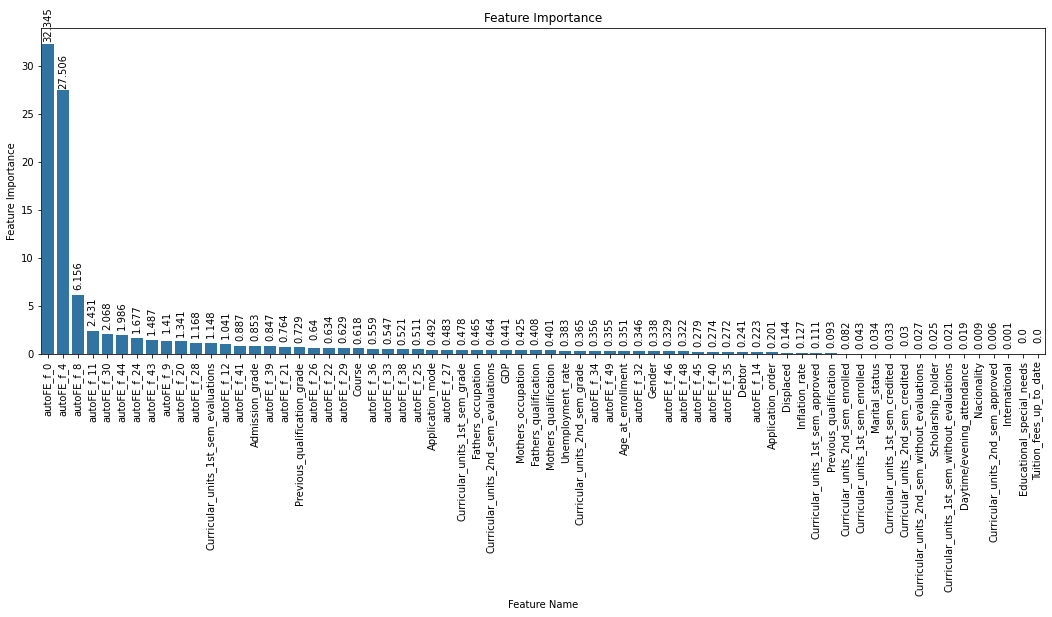

In [296]:
data_utils.plot_feature_importance(df_feature_imp, fig_size=(18, 6))

In [281]:
# from sklearn.ensemble import RandomForestClassifier

# fs_model = RandomForestClassifier(**model_params)
# sfs = SequentialFeatureSelector(model, n_features_to_select=50, scoring="accuracy")
# sfs.fit(df_train[feature_cols_after_fe], df_train[Config.TARGET_COL_NAME])

In [298]:
# performing feature selection by removing bottom 8 features leads to an improvment in cv score for catboost
# from 0.82996 to 0.83129. Forward feature selection algorithm might help to improve cv score further
df_feature_imp = df_feature_imp.head(60)
feature_cols_new = df_feature_imp.f_name.values

In [299]:
cont_features1 = [x for x in df_train[feature_cols_new].dtypes[df_train.dtypes == "float"].index.values if x not in null_features]
scaler1 = StandardScaler()
preprocessor1 = ColumnTransformer(
    transformers=[                
        ("scaler", scaler1, cont_features1),        
    ], remainder="passthrough"
)

In [300]:
fold_metrics_model1, df_oof_preds, preprocessor = tt.train_and_validate(
        model_name=Config.MODEL_TYPE,
        model_params=model_params,
        preprocessor=preprocessor1,
        df=df_train,
        feature_cols=feature_cols_new,
        target_col_name=Config.TARGET_COL_NAME,
        metric=Config.METRIC,
        single_fold=Config.TRAIN_SINGLE_FOLD,
        num_folds=Config.NUM_FOLDS,
        suppress_print=False
)

Fold 0 - CatBoost - ACCURACY : 0.8327259250108098
Fold 1 - CatBoost - ACCURACY : 0.8303168818333436
Fold 2 - CatBoost - ACCURACY : 0.8304299481097109
Fold 3 - CatBoost - ACCURACY : 0.8314183345688164
Fold 4 - CatBoost - ACCURACY : 0.8316036570298987
CatBoost metric=ACCURACY CV score = 0.8312989548071459
CatBoost Mean ACCURACY = 0.8312989493105158, std = 0.0008789742772231881


In [302]:
tt.persist(
    model_name=Config.MODEL_TYPE, 
    fold_metrics_model=fold_metrics_model1, 
    df_oof_preds=df_oof_preds, 
    persist_model=Config.PERSIST_MODEL, 
    output_path=DATA_WRITEPATH
)

Saved validation data predictions to df_val_preds_CatBoost.csv


In [301]:
test_preds_final1 = tt.get_test_preds_clf(fold_metrics_model1, df_test, feature_cols_new, 
                                         preprocessor=preprocessor1, num_folds=Config.NUM_FOLDS)
# convert test_preds to string using labelencoder
test_preds_final1 = le.inverse_transform(test_preds_final1)
print(f"test_preds_final1 shape: {test_preds_final1.shape}")
df_submission = pd.read_csv(SUBMISSION_FILEPATH + 'sample_submission.csv')
df_submission[Config.TARGET_COL_NAME]= test_preds_final1
df_submission.to_csv(DATA_WRITEPATH + f'submission_{Config.MODEL_TYPE}2.csv',index=False)
df_submission.head()

test_X shape: (51012, 60)
combined_test_preds shape: (51012, 3)
test_preds_final1 shape: (51012,)


,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled
